# Final Project Exploratory Analysis

The objective of this notebook is to perform exploratory analysis on a dataset of cell images, some of which are malaria infected and some of whic are healthy, in order to create a model that can predict with high accuracy which is which. The research question to be answered is: 

1. Using only a photo of a blood cell, can I predict with a level of acccuracy equivalent to or higher than microscopy in a lab (97%), whether a Malaria infection is present? 

Plan of Action:

- Prepare the data for analysis:
    - Split data into train and validation groups
    - format the data appropriately for a neural network by scaling and normalizing 
- Start by training a basic tensorflow model to classify the images
- experiment with the model parameters, optimizer, and layers to identify the best fit
- perform additional data augmentation in order to improve the accuracy of the model and reduce any overfitting

Note: for the initial model I am using https://www.tensorflow.org/tutorials/images/classification as a guide

and https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
to guide the tuning process

In [1]:
from google.colab import files
data_to_load = files.upload()

Saving kaggle.json to kaggle (1).json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d syedamirraza/malaria-cell-image

malaria-cell-image.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('malaria-cell-image.zip', 'r')
zip_ref.extractall('Cell_Images')
zip_ref.close()

In [5]:
#Import libraries
import kaggle
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
#Set my data directory *** Test data will only be used in the final report to evaluate my model
train_data_dir = "/content/Cell_Images/cell_images/train"
train_data_dir = pathlib.Path(train_data_dir)

In [7]:
#Set my data directory *** Test data will only be used in the final report to evaluate my model
train_data_dir = "C:/Users/15856/Data 602/FinalProject/Cell_Images/cell_images/train"
train_data_dir = pathlib.Path(train_data_dir)

In [7]:
#I know from my data cleaning notebook that the data images are several different sizes, and so I will set a standard input size for them
batch_size = 32
img_height = 200
img_width = 200

In [8]:
#creating my datasets, one for training and one for validation. I selected 10% of the images for my validation set

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.1, #about 2000 images seems like a good validation set to me
  subset="training",
  seed=1212020,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24958 files belonging to 2 classes.
Using 22463 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.1,
  subset="validation",
  seed=1212020,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24958 files belonging to 2 classes.
Using 2495 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['parasitized', 'uninfected']


## Feature Engineering

In [11]:
# This stage of the data preparation, using AUTOTUNE, is for optimizing performance and allows the tf.data to tune the value dynamically
#https://www.tensorflow.org/guide/data_performance
# The cache function keeps the data in memory after the first epoch which presents bottlenecking during training
#the prefectch function overlaps the data preproccessing with training the model

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Training and Selection

In [12]:
#Finally I will create my model. This is essentially based on the defaults in the tutorial I am using. I will experiment with other activation functions later on
#Furthermore, I will keep many of the inputs, such as a 3x3 Kernel size based on research on the optimal settings https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),#2d convolutional layer over spacial images
  layers.MaxPooling2D(),#max pooling layer for 2D spacial data
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
#again, based on defaults in the tutorial as well as standards for the field. Adam is the basic optimizer to use 

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
#Review model before training
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0

In [15]:
#Train the model

epochs=10 #I will start with 10 epochs and see how the accuracy looks
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 14s 20ms/step - loss: 0.3157 - accuracy: 0.8721 - val_loss: 0.1942 - val_accuracy: 0.9299
Epoch 2/10
702/702 [==============================] - 10s 15ms/step - loss: 0.1683 - accuracy: 0.9417 - val_loss: 0.1642 - val_accuracy: 0.9459
Epoch 3/10
702/702 [==============================] - 10s 15ms/step - loss: 0.1453 - accuracy: 0.9507 - val_loss: 0.1417 - val_accuracy: 0.9575
Epoch 4/10
702/702 [==============================] - 10s 15ms/step - loss: 0.1163 - accuracy: 0.9593 - val_loss: 0.1384 - val_accuracy: 0.9555
Epoch 5/10
702/702 [==============================] - 10s 15ms/step - loss: 0.0861 - accuracy: 0.9700 - val_loss: 0.1477 - val_accuracy: 0.9571
Epoch 6/10
702/702 [==============================] - 10s 15ms/step - loss: 0.0596 - accuracy: 0.9779 - val_loss: 0.1544 - val_accuracy: 0.9555
Epoch 7/10
702/702 [==============================] - 10s 15ms/step - loss: 0.0372 - accuracy: 0.9861 - val_loss: 0.2509 - val_accuracy:

Some observations, the model clearly started overfitting around epoc 5 when the validation accuracy started to decrease, giving a maximum accuracy of around 96%, less than our target.

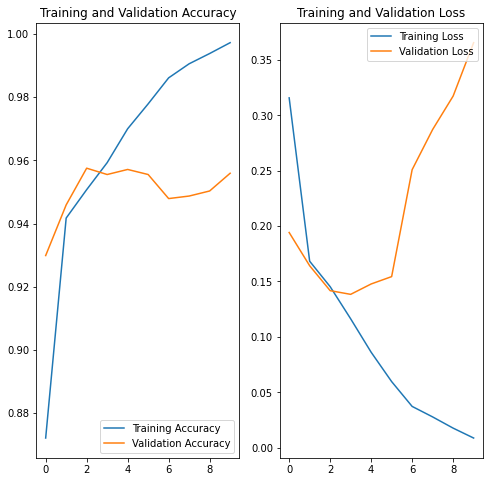

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

To help improve the overfitting, I will add some preproccessing layers to augment the data, specifically rotating, zooming in on, and flipping images.

#https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/PreprocessingLayer
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [17]:
#Made a change to the random flip function, so that it flips vertically and horizontally, creating greater diversity
#This made some improvement on the accuracy
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip(input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

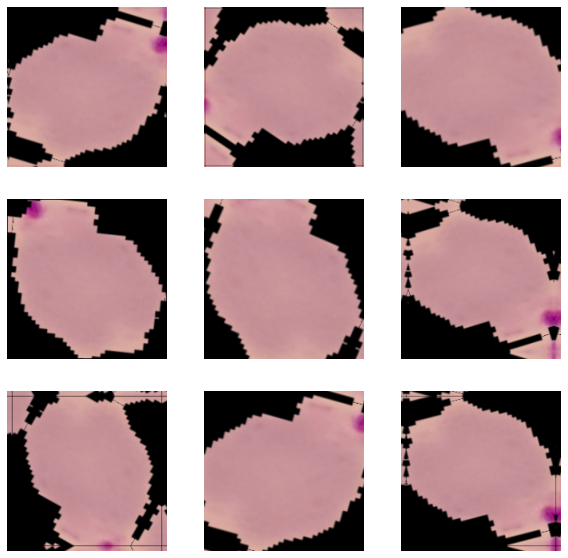

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),#This layer helps to avoid overfitting by randomly setting input units to zero at a rate of 20%
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)       

In [22]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 14s 20ms/step - loss: 0.5385 - accuracy: 0.7086 - val_loss: 0.2076 - val_accuracy: 0.9275
Epoch 2/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1958 - accuracy: 0.9317 - val_loss: 0.1593 - val_accuracy: 0.9515
Epoch 3/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1719 - accuracy: 0.9434 - val_loss: 0.1564 - val_accuracy: 0.9483
Epoch 4/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1601 - accuracy: 0.9504 - val_loss: 0.1299 - val_accuracy: 0.9591
Epoch 5/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1492 - accuracy: 0.9500 - val_loss: 0.1325 - val_accuracy: 0.9595
Epoch 6/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1450 - accuracy: 0.9544 - val_loss: 0.1363 - val_accuracy: 0.9623
Epoch 7/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1440 - accuracy: 0.9535 - val_loss: 0.1364 - val_accuracy:

Here my final accuracy has improved, but is still lower than my 97% target. I will therefore try a few different methods to improve the accuracy

In [23]:
#first, I will try with valid padding, then I will try adding a leakyrelu activation function

model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 13s 19ms/step - loss: 0.4548 - accuracy: 0.7626 - val_loss: 0.2951 - val_accuracy: 0.9038
Epoch 2/10
702/702 [==============================] - 13s 19ms/step - loss: 0.2009 - accuracy: 0.9342 - val_loss: 0.1789 - val_accuracy: 0.9395
Epoch 3/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1834 - accuracy: 0.9399 - val_loss: 0.1546 - val_accuracy: 0.9503
Epoch 4/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1698 - accuracy: 0.9462 - val_loss: 0.1493 - val_accuracy: 0.9551
Epoch 5/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1561 - accuracy: 0.9497 - val_loss: 0.1424 - val_accuracy: 0.9587
Epoch 6/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1451 - accuracy: 0.9537 - val_loss: 0.1273 - val_accuracy: 0.9623
Epoch 7/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1413 - accuracy: 0.9541 - val_loss: 0.1241 - val_accuracy:

The final accuracy was moderately improved. I will now try using the swish activation function

In [26]:
!pip install keras

In [27]:
#Next I wanted to try the swish activation, implemented below
#https://www.bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
import keras
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [28]:
# I will try adding a swish activation function, created by google, it has been shown to perform better than relu, and then I will test leaky relu to se which is optimal
#https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='swish'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='swish'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='swish'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='swish'),
  layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 18s 25ms/step - loss: 0.6310 - accuracy: 0.6442 - val_loss: 0.5486 - val_accuracy: 0.7090
Epoch 2/10
702/702 [==============================] - 18s 25ms/step - loss: 0.3269 - accuracy: 0.8699 - val_loss: 0.1821 - val_accuracy: 0.9327
Epoch 3/10
702/702 [==============================] - 18s 25ms/step - loss: 0.2114 - accuracy: 0.9250 - val_loss: 0.1702 - val_accuracy: 0.9383
Epoch 4/10
702/702 [==============================] - 18s 25ms/step - loss: 0.1848 - accuracy: 0.9350 - val_loss: 0.1549 - val_accuracy: 0.9479
Epoch 5/10
702/702 [==============================] - 18s 25ms/step - loss: 0.1805 - accuracy: 0.9413 - val_loss: 0.1466 - val_accuracy: 0.9583
Epoch 6/10
702/702 [==============================] - 18s 25ms/step - loss: 0.1695 - accuracy: 0.9440 - val_loss: 0.1620 - val_accuracy: 0.9547
Epoch 7/10
702/702 [==============================] - 18s 25ms/step - loss: 0.1659 - accuracy: 0.9461 - val_loss: 0.1492 - val_accuracy:

This did not really change performance. I will next attempt using the leaky relu layer in the model

In [31]:
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid'),
  layers.LeakyReLU(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid'),
  layers.LeakyReLU(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid'),
  layers.LeakyReLU(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 17s 24ms/step - loss: 0.4303 - accuracy: 0.7957 - val_loss: 0.1865 - val_accuracy: 0.9339
Epoch 2/10
702/702 [==============================] - 17s 24ms/step - loss: 0.2223 - accuracy: 0.9278 - val_loss: 0.1665 - val_accuracy: 0.9479
Epoch 3/10
702/702 [==============================] - 17s 24ms/step - loss: 0.1879 - accuracy: 0.9414 - val_loss: 0.1765 - val_accuracy: 0.9395
Epoch 4/10
702/702 [==============================] - 17s 24ms/step - loss: 0.1754 - accuracy: 0.9459 - val_loss: 0.1708 - val_accuracy: 0.9515
Epoch 5/10
702/702 [==============================] - 17s 24ms/step - loss: 0.1583 - accuracy: 0.9499 - val_loss: 0.1318 - val_accuracy: 0.9591
Epoch 6/10
702/702 [==============================] - 17s 24ms/step - loss: 0.1585 - accuracy: 0.9507 - val_loss: 0.1243 - val_accuracy: 0.9603
Epoch 7/10
702/702 [==============================] - 17s 24ms/step - loss: 0.1531 - accuracy: 0.9516 - val_loss: 0.1466 - val_accuracy:

This actually decreased accuracy, I will therefore return to using the relu activation function.

for my next step, I want to see if adding a layer improves output.

In [34]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 14s 19ms/step - loss: 0.3921 - accuracy: 0.8019 - val_loss: 0.1523 - val_accuracy: 0.9567
Epoch 2/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1697 - accuracy: 0.9478 - val_loss: 0.1216 - val_accuracy: 0.9607
Epoch 3/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1545 - accuracy: 0.9509 - val_loss: 0.1345 - val_accuracy: 0.9623
Epoch 4/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1440 - accuracy: 0.9528 - val_loss: 0.1164 - val_accuracy: 0.9627
Epoch 5/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1442 - accuracy: 0.9537 - val_loss: 0.1217 - val_accuracy: 0.9591
Epoch 6/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1373 - accuracy: 0.9550 - val_loss: 0.1163 - val_accuracy: 0.9643
Epoch 7/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1343 - accuracy: 0.9562 - val_loss: 0.1256 - val_accuracy:

This did lead to better performance. I will therefore keep the extra layer in my final model. 

My next step will be to test other optimizers. Based on the recommendations out there: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e ; https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
it seems like Adam is the best of the adaptive optimizers, while SGD (stochastic gradient decent) despite generally being less effective, is still able, in some cases to produce strong results. I will also try Nadam, which incorporates Nesterov Momentum into the adam algorithm (http://cs229.stanford.edu/proj2015/054_report.pdf) and Adamax which is similar to Adam and is therefore worth comparing.

In addition to the optimizers, I used tensorboard to evaluate different dropout rates and the final number of units in the dense layer. 

Note: I used Tensorboard in Google Colab to compare these models directly, but you can also see them written out below

In [37]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [38]:
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer='Nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 14s 21ms/step - loss: 0.3456 - accuracy: 0.8356 - val_loss: 0.1655 - val_accuracy: 0.9575
Epoch 2/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1596 - accuracy: 0.9509 - val_loss: 0.1339 - val_accuracy: 0.9583
Epoch 3/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1523 - accuracy: 0.9521 - val_loss: 0.1242 - val_accuracy: 0.9615
Epoch 4/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1399 - accuracy: 0.9533 - val_loss: 0.1227 - val_accuracy: 0.9631
Epoch 5/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1374 - accuracy: 0.9543 - val_loss: 0.1267 - val_accuracy: 0.9611
Epoch 6/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1340 - accuracy: 0.9559 - val_loss: 0.1114 - val_accuracy: 0.9623
Epoch 7/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1296 - accuracy: 0.9576 - val_loss: 0.1078 - val_accuracy:

In [40]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [41]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 14s 19ms/step - loss: 0.6506 - accuracy: 0.6204 - val_loss: 0.6469 - val_accuracy: 0.6685
Epoch 2/10
702/702 [==============================] - 13s 19ms/step - loss: 0.3994 - accuracy: 0.8347 - val_loss: 0.1964 - val_accuracy: 0.9375
Epoch 3/10
702/702 [==============================] - 13s 19ms/step - loss: 0.2239 - accuracy: 0.9208 - val_loss: 0.2162 - val_accuracy: 0.9194
Epoch 4/10
702/702 [==============================] - 13s 19ms/step - loss: 0.2024 - accuracy: 0.9316 - val_loss: 0.1658 - val_accuracy: 0.9451
Epoch 5/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1918 - accuracy: 0.9367 - val_loss: 0.1576 - val_accuracy: 0.9539
Epoch 6/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1873 - accuracy: 0.9387 - val_loss: 0.1723 - val_accuracy: 0.9395
Epoch 7/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1780 - accuracy: 0.9426 - val_loss: 0.1507 - val_accuracy:

In [43]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [44]:
model.compile(optimizer='Adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 14s 20ms/step - loss: 0.3564 - accuracy: 0.8269 - val_loss: 0.1744 - val_accuracy: 0.9467
Epoch 2/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1873 - accuracy: 0.9340 - val_loss: 0.1543 - val_accuracy: 0.9579
Epoch 3/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1719 - accuracy: 0.9446 - val_loss: 0.1370 - val_accuracy: 0.9623
Epoch 4/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1566 - accuracy: 0.9491 - val_loss: 0.1298 - val_accuracy: 0.9599
Epoch 5/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1502 - accuracy: 0.9505 - val_loss: 0.1307 - val_accuracy: 0.9571
Epoch 6/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1402 - accuracy: 0.9527 - val_loss: 0.1261 - val_accuracy: 0.9631
Epoch 7/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1382 - accuracy: 0.9530 - val_loss: 0.1153 - val_accuracy:

Next I will test across different units (between 128 and 256) for the dense layer. I will then test the outputs with a dropout rate of .1

In [46]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 14s 20ms/step - loss: 0.3174 - accuracy: 0.8598 - val_loss: 0.1653 - val_accuracy: 0.9499
Epoch 2/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1652 - accuracy: 0.9488 - val_loss: 0.1354 - val_accuracy: 0.9579
Epoch 3/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1534 - accuracy: 0.9508 - val_loss: 0.1210 - val_accuracy: 0.9611
Epoch 4/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1491 - accuracy: 0.9516 - val_loss: 0.1251 - val_accuracy: 0.9615
Epoch 5/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1430 - accuracy: 0.9517 - val_loss: 0.1141 - val_accuracy: 0.9663
Epoch 6/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1389 - accuracy: 0.9554 - val_loss: 0.1153 - val_accuracy: 0.9635
Epoch 7/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1375 - accuracy: 0.9552 - val_loss: 0.1147 - val_accuracy:

In [49]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [50]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 14s 19ms/step - loss: 0.6800 - accuracy: 0.5660 - val_loss: 0.6580 - val_accuracy: 0.5940
Epoch 2/10
702/702 [==============================] - 13s 19ms/step - loss: 0.6207 - accuracy: 0.6628 - val_loss: 0.4979 - val_accuracy: 0.7804
Epoch 3/10
702/702 [==============================] - 13s 19ms/step - loss: 0.3468 - accuracy: 0.8602 - val_loss: 0.2668 - val_accuracy: 0.9327
Epoch 4/10
702/702 [==============================] - 13s 19ms/step - loss: 0.2380 - accuracy: 0.9188 - val_loss: 0.1971 - val_accuracy: 0.9343
Epoch 5/10
702/702 [==============================] - 13s 19ms/step - loss: 0.2154 - accuracy: 0.9282 - val_loss: 0.1748 - val_accuracy: 0.9479
Epoch 6/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1978 - accuracy: 0.9340 - val_loss: 0.1577 - val_accuracy: 0.9523
Epoch 7/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1914 - accuracy: 0.9379 - val_loss: 0.1524 - val_accuracy:

In [52]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [53]:
model.compile(optimizer='Nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 15s 21ms/step - loss: 0.5116 - accuracy: 0.7062 - val_loss: 0.1497 - val_accuracy: 0.9519
Epoch 2/10
702/702 [==============================] - 15s 21ms/step - loss: 0.1669 - accuracy: 0.9481 - val_loss: 0.1260 - val_accuracy: 0.9631
Epoch 3/10
702/702 [==============================] - 15s 21ms/step - loss: 0.1479 - accuracy: 0.9522 - val_loss: 0.1323 - val_accuracy: 0.9603
Epoch 4/10
702/702 [==============================] - 15s 21ms/step - loss: 0.1420 - accuracy: 0.9536 - val_loss: 0.1223 - val_accuracy: 0.9619
Epoch 5/10
702/702 [==============================] - 15s 21ms/step - loss: 0.1374 - accuracy: 0.9540 - val_loss: 0.1274 - val_accuracy: 0.9615
Epoch 6/10
702/702 [==============================] - 15s 21ms/step - loss: 0.1345 - accuracy: 0.9553 - val_loss: 0.1119 - val_accuracy: 0.9627
Epoch 7/10
702/702 [==============================] - 15s 21ms/step - loss: 0.1310 - accuracy: 0.9558 - val_loss: 0.1204 - val_accuracy:

In [55]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [56]:
model.compile(optimizer='Adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 14s 20ms/step - loss: 0.3575 - accuracy: 0.8353 - val_loss: 0.1834 - val_accuracy: 0.9387
Epoch 2/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1889 - accuracy: 0.9383 - val_loss: 0.1568 - val_accuracy: 0.9507
Epoch 3/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1707 - accuracy: 0.9463 - val_loss: 0.1402 - val_accuracy: 0.9623
Epoch 4/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1604 - accuracy: 0.9482 - val_loss: 0.1292 - val_accuracy: 0.9619
Epoch 5/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1504 - accuracy: 0.9510 - val_loss: 0.1284 - val_accuracy: 0.9591
Epoch 6/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1434 - accuracy: 0.9542 - val_loss: 0.1288 - val_accuracy: 0.9587
Epoch 7/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1390 - accuracy: 0.9542 - val_loss: 0.1130 - val_accuracy:

Result

Finally I will test with a dropout rate of 10%

In [58]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [59]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 14s 19ms/step - loss: 0.3639 - accuracy: 0.8245 - val_loss: 0.1454 - val_accuracy: 0.9591
Epoch 2/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1672 - accuracy: 0.9486 - val_loss: 0.1311 - val_accuracy: 0.9595
Epoch 3/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1516 - accuracy: 0.9534 - val_loss: 0.1305 - val_accuracy: 0.9599
Epoch 4/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1459 - accuracy: 0.9533 - val_loss: 0.1138 - val_accuracy: 0.9659
Epoch 5/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1381 - accuracy: 0.9557 - val_loss: 0.1124 - val_accuracy: 0.9639
Epoch 6/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1356 - accuracy: 0.9552 - val_loss: 0.1053 - val_accuracy: 0.9663
Epoch 7/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1352 - accuracy: 0.9562 - val_loss: 0.1072 - val_accuracy:

In [61]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [62]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 14s 19ms/step - loss: 0.6805 - accuracy: 0.5667 - val_loss: 0.6529 - val_accuracy: 0.6349
Epoch 2/10
702/702 [==============================] - 13s 19ms/step - loss: 0.6320 - accuracy: 0.6500 - val_loss: 0.5326 - val_accuracy: 0.7543
Epoch 3/10
702/702 [==============================] - 14s 20ms/step - loss: 0.3812 - accuracy: 0.8356 - val_loss: 0.1978 - val_accuracy: 0.9275
Epoch 4/10
702/702 [==============================] - 13s 19ms/step - loss: 0.2350 - accuracy: 0.9187 - val_loss: 0.1784 - val_accuracy: 0.9399
Epoch 5/10
702/702 [==============================] - 13s 19ms/step - loss: 0.2084 - accuracy: 0.9318 - val_loss: 0.1618 - val_accuracy: 0.9535
Epoch 6/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1948 - accuracy: 0.9387 - val_loss: 0.1643 - val_accuracy: 0.9495
Epoch 7/10
702/702 [==============================] - 13s 19ms/step - loss: 0.1844 - accuracy: 0.9428 - val_loss: 0.1531 - val_accuracy:

In [64]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [65]:
model.compile(optimizer='Nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 15s 21ms/step - loss: 0.4755 - accuracy: 0.7184 - val_loss: 0.1583 - val_accuracy: 0.9623
Epoch 2/10
702/702 [==============================] - 14s 21ms/step - loss: 0.1649 - accuracy: 0.9485 - val_loss: 0.1249 - val_accuracy: 0.9623
Epoch 3/10
702/702 [==============================] - 14s 21ms/step - loss: 0.1545 - accuracy: 0.9491 - val_loss: 0.1248 - val_accuracy: 0.9647
Epoch 4/10
702/702 [==============================] - 14s 21ms/step - loss: 0.1426 - accuracy: 0.9543 - val_loss: 0.1194 - val_accuracy: 0.9607
Epoch 5/10
702/702 [==============================] - 15s 21ms/step - loss: 0.1371 - accuracy: 0.9553 - val_loss: 0.1211 - val_accuracy: 0.9631
Epoch 6/10
702/702 [==============================] - 14s 21ms/step - loss: 0.1336 - accuracy: 0.9545 - val_loss: 0.1150 - val_accuracy: 0.9603
Epoch 7/10
702/702 [==============================] - 14s 21ms/step - loss: 0.1323 - accuracy: 0.9556 - val_loss: 0.1303 - val_accuracy:

In [67]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [68]:
model.compile(optimizer='Adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [69]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 14s 20ms/step - loss: 0.4823 - accuracy: 0.7545 - val_loss: 0.1954 - val_accuracy: 0.9246
Epoch 2/10
702/702 [==============================] - 14s 19ms/step - loss: 0.2075 - accuracy: 0.9241 - val_loss: 0.1566 - val_accuracy: 0.9543
Epoch 3/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1831 - accuracy: 0.9390 - val_loss: 0.1491 - val_accuracy: 0.9563
Epoch 4/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1713 - accuracy: 0.9457 - val_loss: 0.1364 - val_accuracy: 0.9603
Epoch 5/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1663 - accuracy: 0.9474 - val_loss: 0.1352 - val_accuracy: 0.9607
Epoch 6/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1620 - accuracy: 0.9487 - val_loss: 0.1305 - val_accuracy: 0.9635
Epoch 7/10
702/702 [==============================] - 14s 19ms/step - loss: 0.1518 - accuracy: 0.9505 - val_loss: 0.1328 - val_accuracy:

Okay! So my best results seem to have come from the model with one additional layer (128 filters), valid padding, relu activation function, and the nadam activation function. Below is my final training model and the result of that model on test data!

In [70]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [71]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling_17 (Rescaling)     (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 46, 46, 64)      

In [72]:
model.compile(optimizer='Nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [73]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 14s 21ms/step - loss: 0.3056 - accuracy: 0.8677 - val_loss: 0.1554 - val_accuracy: 0.9559
Epoch 2/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1661 - accuracy: 0.9473 - val_loss: 0.1350 - val_accuracy: 0.9611
Epoch 3/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1487 - accuracy: 0.9516 - val_loss: 0.1337 - val_accuracy: 0.9651
Epoch 4/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1419 - accuracy: 0.9528 - val_loss: 0.1173 - val_accuracy: 0.9651
Epoch 5/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1389 - accuracy: 0.9549 - val_loss: 0.1195 - val_accuracy: 0.9631
Epoch 6/10
702/702 [==============================] - 14s 20ms/step - loss: 0.1360 - accuracy: 0.9542 - val_loss: 0.1246 - val_accuracy: 0.9647
Epoch 7/10
702/702 [==============================] - 14s 21ms/step - loss: 0.1307 - accuracy: 0.9566 - val_loss: 0.1258 - val_accuracy:

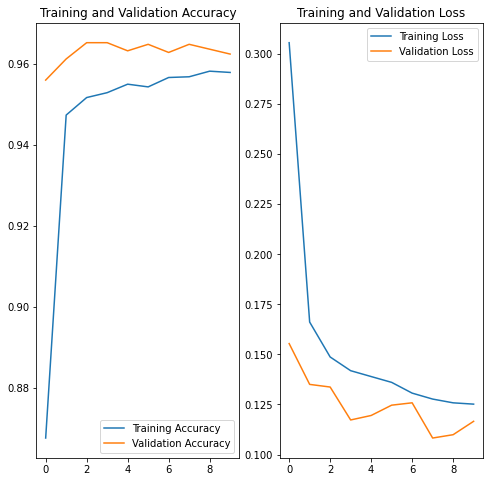

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [78]:
#preparing my test data for the model

test_data_dir = "/content/Cell_Images/cell_images/train"

In [79]:
batch_size = 32
img_height = 200
img_width = 200

In [80]:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  seed=1212020,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24958 files belonging to 2 classes.


In [81]:
model.evaluate(test_ds)

780/780 [==============================] - 46s 59ms/step - loss: 0.1201 - accuracy: 0.9609


[0.12013625353574753, 0.9608542323112488]